In [11]:
#@title Basic Libaries { run: "auto" }
#@markdown Getting started with the essential libraries

import os
import sys
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
sb.set(style="darkgrid", context="talk")
plt.style.use("dark_background")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.rcParams["figure.figsize"] = (40,10)

# Add-on preferences
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings as wn
wn.simplefilter(action="ignore", category=FutureWarning)

from copy import deepcopy

In [12]:
#@title Global Attributes { run: "auto" }
#@markdown Define environment states

onDrive = False #@param {type:"boolean"}

try:
  import google.colab
  onColab = True

  from google.colab import files
  
  if onDrive:
    from google.colab import drive
    drive.mount('drive')
except ImportError or ModuleNotFoundError:
  onColab = False
  onDrive = False

print(f"Using Google Colab: {onColab}");
print(f"Using Google Drive: {onDrive}");

Using Google Colab: True
Using Google Drive: False


# Data Analysis

---

In [13]:
#@title Set Coin Ticker { run: "auto" }
#@markdown Define the ticker in the data

coinSymbols = 'BTC' #@param ["BTC", "ETH"]{allow-input: true}

# List crypto tickers
coins = [coinSymbols]
coinTickers = [f"{c}-USD" for c in coins]

coinTicker = coinTickers[0]

coinTicker

'BTC-USD'

In [14]:
#@title Data Import { run: "auto" }

fileName = f"{coinTicker.split('-')[0]}-SearchTrend.csv"
folderPath = "" #@param {type:"string"}
if len(folderPath) > 0 and not folderPath.endswith('/'):
  folderPath += '/'

if onColab:
  if onDrive:
    folderPath = f'/content/drive/My Drive/{folderPath if len(folderPath) > 0 else ""}'
  else:
    folderPath = f"/content/{folderPath if len(folderPath) > 0 else ''}"
else:
  BASE_DIR = os.getcwd()
  folderPath = os.path.join(BASE_DIR, f"{folderPath if len(folderPath) > 0 else ''}")
filePath = f'{folderPath}{fileName}'

# Import CSV 
try:
  rawData = pd.read_csv(filePath, header=0, index_col=0)
  rawData.index = pd.to_datetime(rawData.index)

  # Preview data
  rawData.head()
  rawData.shape
except FileNotFoundError:
    print("ERROR - FILE NOT FOUND. [Run 'Data Preprocess' to export the file.]")

,OPEN,HIGH,LOW,CLOSE,VOLUME,BITCOIN,CRYPTOCURRENCY
DATE,,,,,,,
2017-01-01,963.66,"1,003.08",958.70,998.33,147775008,37.00,18.00
2017-01-02,998.62,"1,031.39",996.70,"1,021.75",222184992,61.00,27.00
2017-01-03,"1,021.60","1,044.08","1,021.60","1,043.84",185168000,59.00,34.00
2017-01-04,"1,044.40","1,159.42","1,044.40","1,154.73",344945984,66.00,32.00
2017-01-05,"1,156.73","1,191.10",910.42,"1,013.38",510199008,82.00,34.00


(1936, 7)

## Data Preprocess

---

In [15]:
#@title Data Overview { run: "auto" }

print(f"{'- '*15} INFO {'- '*15}\n")
rawData.info()

print(f"{'- '*15} DESCRIBE {'- '*15}\n")
rawData.describe()

- - - - - - - - - - - - - - -  INFO - - - - - - - - - - - - - - - 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1936 entries, 2017-01-01 to 2022-04-20
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OPEN            1936 non-null   float64
 1   HIGH            1936 non-null   float64
 2   LOW             1936 non-null   float64
 3   CLOSE           1936 non-null   float64
 4   VOLUME          1936 non-null   int64  
 5   BITCOIN         1936 non-null   float64
 6   CRYPTOCURRENCY  1936 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 121.0 KB
- - - - - - - - - - - - - - -  DESCRIBE - - - - - - - - - - - - - - - 



,OPEN,HIGH,LOW,CLOSE,VOLUME,BITCOIN,CRYPTOCURRENCY
count,"1,936.00","1,936.00","1,936.00","1,936.00","1,936.00","1,936.00","1,936.00"
mean,"16,962.48","17,412.21","16,468.55","16,981.24","21,413,205,923.24",63.17,47.43
std,"17,578.72","18,036.64","17,051.36","17,579.51","20,728,747,158.38",13.53,11.85
min,775.18,823.31,755.76,777.76,"60,851,700.00",7.00,11.00
25%,"5,937.57","6,191.92","5,774.10","5,974.36","4,835,379,100.25",56.00,40.00
50%,"8,939.35","9,201.87","8,788.03","8,964.93","17,504,715,049.50",66.00,48.00
75%,"23,539.23","24,066.45","22,808.60","23,747.72","32,510,444,835.50",73.00,56.00
max,"67,549.73","68,789.62","66,382.06","67,566.83","350,967,941,479.00",91.00,80.00


In [16]:
#@title Data Screening { run: "auto" }
#@markdown Check for null values

print('NULL values:',rawData.isnull().values.sum())
print('NA values:',rawData.isnull().values.any())
print('SHAPE:',rawData.shape)

NULL values: 0
NA values: False
SHAPE: (1936, 7)


# Models

---

In [23]:
#@title Add-on Libaries { run: "auto" }

if onColab:
  !{sys.executable} -m pip install -q plotly sklearn tensorflow

import plotly.express as px
# from plotly.offline import plot, iplot, init_notebook_mode
# init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_poisson_deviance, mean_gamma_deviance, accuracy_score, confusion_matrix, f1_score

from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM

import math
from math import sqrt

In [24]:
#@title Model Data Extraction  { run: "auto" }
#@markdown Store a copy of the dataset

data = deepcopy(rawData)
# Filter out predictor columns (Search Terms)
tickerCols = ['Open','High','Low','Close','Volume']
searchCols = list(set(rawData.columns)-set(t.upper() for t in tickerCols))

response = 'CLOSE' #@param ["CLOSE", "OPEN", "HIGH", "LOW"]{allow-input: true}
mainData = deepcopy(rawData)[[response]][rawData.index >= f'{rawData.iloc[-1].name.year - 2}-01-01']

mainData.tail()
mainData.shape

,CLOSE
DATE,
2022-04-16,"40,424.48"
2022-04-17,"39,716.95"
2022-04-18,"40,826.21"
2022-04-19,"41,502.75"
2022-04-20,"41,833.21"


(841, 1)

## Rolling Forcast ARIMA
---

<br/>

*References*
* [Forecasting BTC](https://www.kaggle.com/code/aaronfloreani/forecasting-btc-arima-xgboost-prophet-lstm/notebook)

In [25]:
#@title Add-on Libaries { run: "auto" }

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

In [26]:
#@title Train/Test Split { run: "auto" }
#@markdown Dataset is splitted into two groups which are train and test sets.

modelType = "rollingARIMA"
data = deepcopy(mainData)

# Train 70%, Test 30%
X = data.values
trainSize = int(len(X) * 0.7)
trainData, testData = X[0:trainSize], X[trainSize:len(X)]

In [27]:
#@title Model Prediction { run: "auto" }
#@markdown Using the LSTM model to predict Train / Test values

# Prediction process is performed for Train/Test dataset
history = [x for x in trainData]
predictions = list()
for t in range(len(testData)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = testData[t]
	history.append(obs)
	# print('predicted=%f, expected=%f' % (yhat, obs))

testPredict = pd.DataFrame(predictions, columns=[response])
testReal = pd.DataFrame(testData, columns=[f'{response}-real'])

# Model Evaluation
trainMetrics = {
    'RMSE': math.nan,
    'MSE': math.nan,
    'MAE': math.nan,
    'EV': math.nan,
    'R2':  math.nan,
    'MGD':  math.nan,
    'MPD':  math.nan,
}
testMetrics = {
    'RMSE': sqrt(mean_squared_error(testReal,testPredict)),
    'MSE': mean_squared_error(testReal,testPredict),
    'MAE': mean_absolute_error(testReal,testPredict),
    'EV': explained_variance_score(testReal, testPredict),
    'R2':  r2_score(testReal, testPredict),
    'MGD':  mean_gamma_deviance(testReal, testPredict),
    'MPD':   mean_poisson_deviance(testReal, testPredict),
}

# Compile/Export Metrics
metrics = {}
metrics[modelType] = {
  'TRAIN':trainMetrics,
  'TEST':testMetrics
}

exportJSON = True #@param {type:"boolean"}

# Export to CSV
if exportJSON:
  allMetrics = pd.DataFrame.from_dict(metrics,orient='columns')
  
  fileName = f"{modelType}_metrics.json"
  folderPath = "" #@param {type:"string"} 
  if len(folderPath) > 0 and not folderPath.endswith('/'):
    folderPath += '/'
  filePath = f'{folderPath if len(folderPath) > 0 else ""}{fileName}'

  if onColab:
    if onDrive:
      filePath = f'/content/drive/My Drive/{filePath}'
      allMetrics.to_json(filePath, orient='columns')
      print(f"SUCCESSFULLY EXPORTED to [{filePath}]")
    else:
      allMetrics.to_json(fileName, orient='columns')
      files.download(fileName)
      print(f"SUCCESSFULLY EXPORTED to [{fileName}]")

  else:
    BASE_DIR = os.getcwd()
    filePath = os.path.join(BASE_DIR, filePath)
    allMetrics.to_json(filePath, orient='columns')
    print(f"SUCCESSFULLY EXPORTED to [{filePath}]")


# Display summary sorted by R-squared (R2) in descending order
pd.DataFrame.from_dict({(i,j): metrics[i][j] 
                            for i in metrics.keys() 
                            for j in metrics[i].keys()},
                        orient='index').rename_axis("TYPE", axis=1).sort_values(by="R2", ascending=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SUCCESSFULLY EXPORTED to [rollingARIMA_metrics.json]


TYPE                   RMSE          MSE      MAE   EV   R2  MGD   MPD
rollingARIMA TEST  1,634.19 2,670,569.98 1,192.10 0.96 0.96 0.00 55.52
             TRAIN      NaN          NaN      NaN  NaN  NaN  NaN   NaN

In [28]:
#@title Metrics Summary Import { run: "auto" }
#@markdown Compare and export the model metrics

importMetrics = True #@param {type:"boolean"}

if importMetrics:
  fileName = f"{modelType}_metrics.json"
  folderPath = "" #@param {type:"string"} 

  if onColab:
    if onDrive:
      folderPath = f'/content/drive/My Drive/{folderPath if len(folderPath) > 0 else ""}'
    else:
      folderPath = f"/content/{folderPath if len(folderPath) > 0 else ''}"
  else:
    BASE_DIR = os.getcwd()
    folderPath = os.path.join(BASE_DIR, f"{folderPath if len(folderPath) > 0 else ''}")
  filePath = f'{folderPath}{fileName}'

  # Import CSV 
  try:
    sm = pd.read_json(filePath, orient="columns")
    # Display summary sorted by R-squared (R2) in descending order
    pd.DataFrame.from_dict({(i,j): sm[i][j] 
                              for i in sm.keys() 
                              for j in sm[i].keys()},
                          orient='index').rename_axis("TYPE", axis=1).sort_values(by="R2", ascending=False)
  except FileNotFoundError:
      print("ERROR - FILE NOT FOUND. [Run 'Data Preprocess' to export the file.]")

TYPE                   RMSE          MSE      MAE   EV   R2  MGD   MPD
rollingARIMA TEST  1,634.19 2,670,569.98 1,192.10 0.96 0.96 0.00 55.52
             TRAIN      NaN          NaN      NaN  NaN  NaN  NaN   NaN

,CLOSE_real,CLOSE_pred
DATE,,
2021-08-11,"45,593.64","45,910.49"
2021-08-12,"44,428.29","45,658.72"
2021-08-13,"47,793.32","44,644.19"
2021-08-14,"47,096.95","47,371.70"
2021-08-15,"47,047.00","47,485.65"
...,...,...
2022-04-16,"40,424.48","40,593.69"
2022-04-17,"39,716.95","40,497.93"
2022-04-18,"40,826.21","39,743.20"


Text(0.5, 1.0, 'BTC-USD Prediction Comparison')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Valuation in USD')

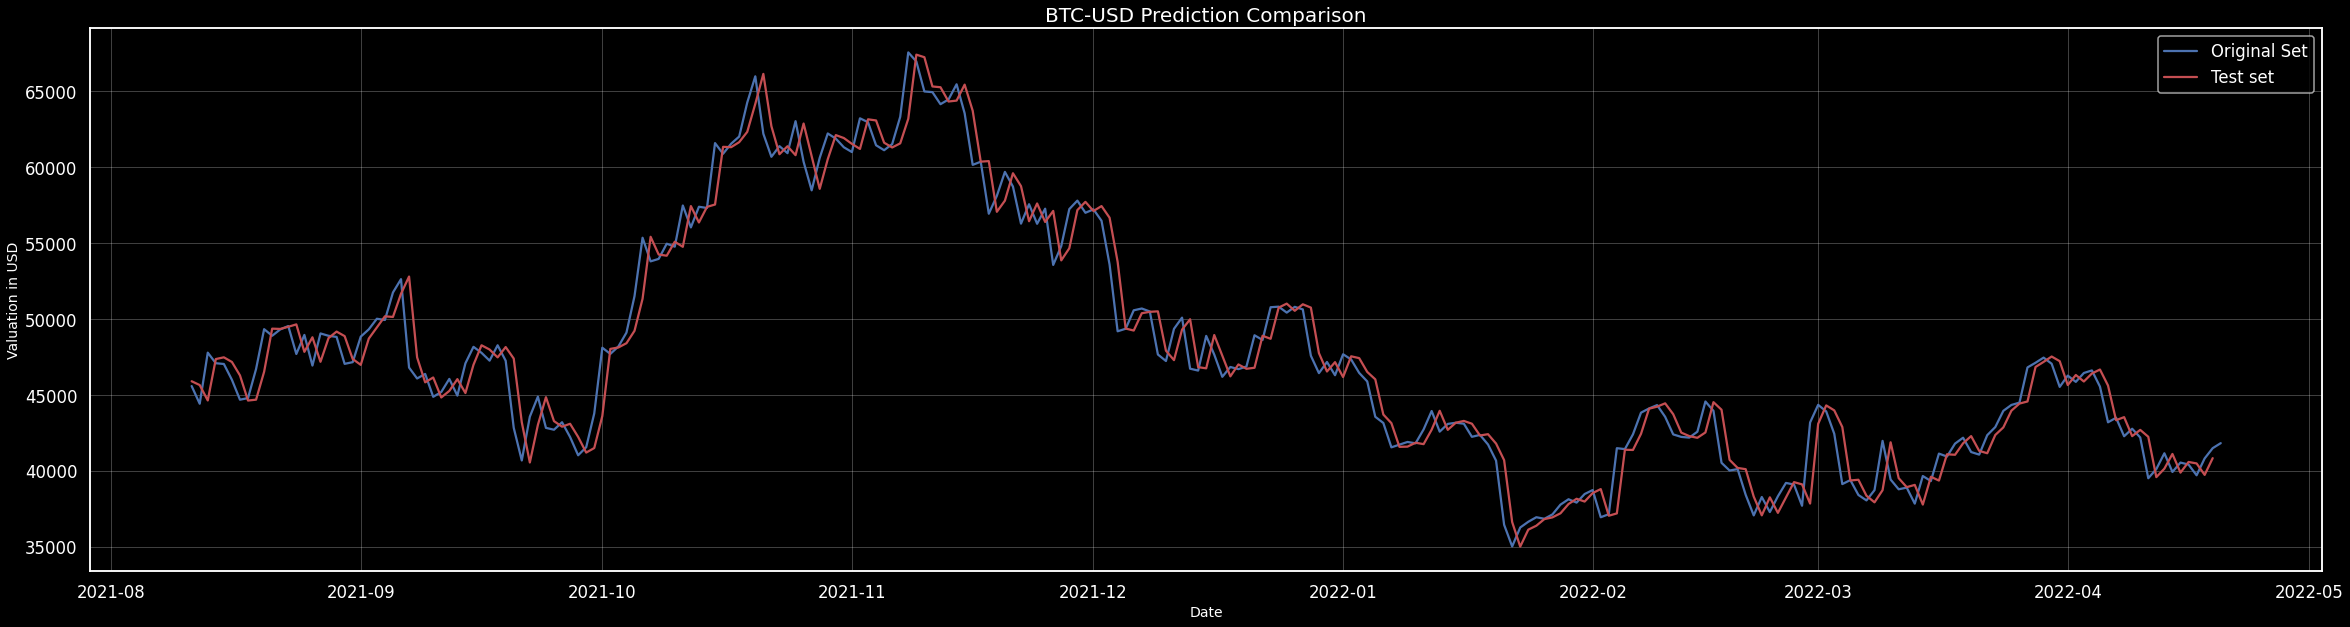

In [29]:
#@title Prediction Comparison { run: "auto" }
#@markdown Compare the actual vs predicted value
showDataframe = True #@param {type:"boolean"}
showTimeRange = False #@param {type:"boolean"}

predData = deepcopy(testPredict)
predData.index = data[trainSize:len(X)].index
predData.index.names = ['DATE']
realData = deepcopy(data)

responseData = pd.merge(realData, predData, on="DATE", how='inner' , suffixes=('_real', '_pred'))
if showDataframe:
  responseData

# Visualisation of LTSM prediction
if showTimeRange:
  fig = px.line(responseData, x=responseData.index, y=responseData.columns, title=f'{coinTicker} Prediction Comparison')
  fig.update_xaxes(
      rangeslider_visible=True,
      rangeselector=dict(
          buttons=list([
              dict(count=1, label="1m", step="month", stepmode="backward"),
              dict(count=6, label="6m", step="month", stepmode="backward"),
              dict(count=1, label="YTD", step="year", stepmode="todate"),
              dict(count=1, label="1y", step="year", stepmode="backward"),
              dict(step="all")
          ])
      )
  )
else:
  fg = plt.figure(figsize=(40, 10))
  sb.lineplot(data=responseData, y=responseData[f"{response}_real"], color='b', x="DATE", label='Original Set')
  sb.lineplot(data=responseData, y=responseData[f"{response}_pred"][0:len(testPredict)-1], color='r' , x="DATE", label='Test set')
  # sb.lineplot(data=responseData, y=responseData[f"{response}_pred"][len(testPredict)-1:len(responseData)], color='g', x="DATE", label='Predicted/Test set')
  plt.title(f'{coinTicker} Prediction Comparison', fontsize=20);
  plt.xlabel("Date", fontsize=14)
  plt.ylabel("Valuation in USD", fontsize=14)

## XGBoost

In [30]:
#@title Normalisation { run: "auto" }
#@markdown Dataset values are normalized by using MinMax method.

data = deepcopy(mainData)

scaler = MinMaxScaler(feature_range=(0,1))
# scaledData = scaler.fit_transform(np.reshape(data.values, (len(data),1)))
scaledData = scaler.fit_transform(np.array(data).reshape(-1,1))

# Preview dataset
pd.concat([data.reset_index(), pd.DataFrame(scaledData, columns=[f'SCALED-{response}'])], axis=1)

,DATE,CLOSE,SCALED-CLOSE
0,2020-01-01,"7,200.17",0.04
1,2020-01-02,"6,985.47",0.03
2,2020-01-03,"7,344.88",0.04
3,2020-01-04,"7,410.66",0.04
4,2020-01-05,"7,411.32",0.04
...,...,...,...
836,2022-04-16,"40,424.48",0.57
837,2022-04-17,"39,716.95",0.56
838,2022-04-18,"40,826.21",0.57
839,2022-04-19,"41,502.75",0.58


In [31]:
#@title Train/Test Split { run: "auto" }
#@markdown Dataset is splitted into two groups which are train and test sets.

modelData = deepcopy(scaledData)
trainSize = int(len(modelData)*0.60)
testSize = len(modelData)-trainSize
trainData, testData = modelData[0:trainSize,:],modelData[trainSize:len(modelData),:1]

# Normalized values are converted into Time-Series.
def to_singleDim(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 1
trainX, trainY = to_singleDim(trainData, time_step)
testX, testY = to_singleDim(testData, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
trainX = trainX.reshape(trainX.shape[0],trainX.shape[1])
testX = testX.reshape(testX.shape[0],testX.shape[1])

pd.DataFrame({
  'X':{
    'Train': trainX.shape,
    'Test': testX.shape,
  },
  'Y':{
    'Train': trainY.shape,
    'Test': testY.shape,
  }
})

,X,Y
Train,"(502, 1)","(502,)"
Test,"(335, 1)","(335,)"


In [32]:
#@title Model Initialisation { run: "auto" }
#@markdown XGBoost model is created

modelType = 'XGBoost'
model = XGBRegressor(objective ='reg:linear', verbosity = 0, silent=True, random_state=42, n_estimators=1000)

# Dataset is trained by using trainX and trainY
model.fit(trainX, trainY, eval_set=[(trainX, trainY), (testX, testY)], verbose=True)

exportModel = True #@param {type:"boolean"}

# Export Model
if exportModel:
  fileName = f"{coinTicker.split('-')[0]}-{modelType}.txt"
  folderPath = "" #@param {type:"string"} 
  if len(folderPath) > 0 and not folderPath.endswith('/'):
    folderPath += '/'
  filePath = f'{folderPath if len(folderPath) > 0 else ""}{fileName}'

  if onColab:
    if onDrive:
      filePath = f'/content/drive/My Drive/{filePath}'
      model.save_model(filePath)
      print(f"SUCCESSFULL EXPORTED to [{filePath}]")
    else:
      model.save_model(fileName)
      files.download(fileName)
      print(f"SUCCESSFULL EXPORTED to [{fileName}]")
  else:
    BASE_DIR = os.getcwd()
    filePath = os.path.join(BASE_DIR, filePath)
    model.save_model(filePath, encoding='utf-8', index=False)
    print(f"SUCCESSFULL EXPORTED to [{filePath}]")

[0]	validation_0-rmse:0.335266	validation_1-rmse:0.177319
[1]	validation_0-rmse:0.302277	validation_1-rmse:0.162031
[2]	validation_0-rmse:0.272572	validation_1-rmse:0.147892
[3]	validation_0-rmse:0.245829	validation_1-rmse:0.135285
[4]	validation_0-rmse:0.221734	validation_1-rmse:0.124451
[5]	validation_0-rmse:0.200038	validation_1-rmse:0.114346
[6]	validation_0-rmse:0.180502	validation_1-rmse:0.105328
[7]	validation_0-rmse:0.162922	validation_1-rmse:0.097117
[8]	validation_0-rmse:0.147084	validation_1-rmse:0.089772
[9]	validation_0-rmse:0.132826	validation_1-rmse:0.083619
[10]	validation_0-rmse:0.119999	validation_1-rmse:0.078184
[11]	validation_0-rmse:0.108463	validation_1-rmse:0.072739
[12]	validation_0-rmse:0.098092	validation_1-rmse:0.068254
[13]	validation_0-rmse:0.08875	validation_1-rmse:0.063841
[14]	validation_0-rmse:0.08037	validation_1-rmse:0.060096
[15]	validation_0-rmse:0.07284	validation_1-rmse:0.056634
[16]	validation_0-rmse:0.066091	validation_1-rmse:0.053354
[17]	valid

XGBRegressor(n_estimators=1000, random_state=42, silent=True, verbosity=0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SUCCESSFULL EXPORTED to [BTC-XGBoost.txt]


In [33]:
#@title Model Prediction { run: "auto" }
#@markdown Using the XGBoost model to predict Train / Test values

# Prediction process is performed for Train/Test dataset
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# DE-Normalizing for plotting 
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1,1))
testPredict = scaler.inverse_transform(testPredict.reshape(-1,1))
trainReal = scaler.inverse_transform(trainY.reshape(-1,1)) 
testReal = scaler.inverse_transform(testY.reshape(-1,1)) 

# Model Evaluation
trainMetrics = {
    'RMSE': sqrt(mean_squared_error(trainReal,trainPredict)),
    'MSE': mean_squared_error(trainReal,trainPredict),
    'MAE': mean_absolute_error(trainReal,trainPredict),
    'EV': explained_variance_score(trainReal, trainPredict),
    'R2':  r2_score(trainReal, trainPredict),
    'MGD':  mean_gamma_deviance(trainReal, trainPredict),
    'MPD':  mean_poisson_deviance(trainReal, trainPredict),
}
testMetrics = {
    'RMSE': sqrt(mean_squared_error(testReal,testPredict)),
    'MSE': mean_squared_error(testReal,testPredict),
    'MAE': mean_absolute_error(testReal,testPredict),
    'EV': explained_variance_score(testReal, testPredict),
    'R2':  r2_score(testReal, testPredict),
    'MGD':  mean_gamma_deviance(testReal, testPredict),
    'MPD':   mean_poisson_deviance(testReal, testPredict),
}

# Compile/Export Metrics
metrics = {}
metrics[modelType] = {
  'TRAIN':trainMetrics,
  'TEST':testMetrics
}

exportJSON = True #@param {type:"boolean"}

# Export to CSV
if exportJSON:
  allMetrics = pd.DataFrame.from_dict(metrics,orient='columns')
  
  fileName = f"{modelType}_metrics.json"
  folderPath = "" #@param {type:"string"} 
  if len(folderPath) > 0 and not folderPath.endswith('/'):
    folderPath += '/'
  filePath = f'{folderPath if len(folderPath) > 0 else ""}{fileName}'

  if onColab:
    if onDrive:
      filePath = f'/content/drive/My Drive/{filePath}'
      allMetrics.to_json(filePath, orient='columns')
      print(f"SUCCESSFULLY EXPORTED to [{filePath}]")
    else:
      allMetrics.to_json(fileName, orient='columns')
      files.download(fileName)
      print(f"SUCCESSFULLY EXPORTED to [{fileName}]")

  else:
    BASE_DIR = os.getcwd()
    filePath = os.path.join(BASE_DIR, filePath)
    allMetrics.to_json(filePath, orient='columns')
    print(f"SUCCESSFULLY EXPORTED to [{filePath}]")


# Display summary sorted by R-squared (R2) in descending order
pd.DataFrame.from_dict({(i,j): metrics[i][j] 
                            for i in metrics.keys() 
                            for j in metrics[i].keys()},
                        orient='index').rename_axis("TYPE", axis=1).sort_values(by="R2", ascending=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SUCCESSFULLY EXPORTED to [XGBoost_metrics.json]


TYPE              RMSE          MSE      MAE   EV   R2  MGD    MPD
XGBoost TRAIN   270.66    73,258.47   194.32 1.00 1.00 0.00   4.32
        TEST  2,675.77 7,159,763.50 2,081.96 0.90 0.90 0.00 159.05

In [34]:
#@title Metrics Summary Import { run: "auto" }
#@markdown Compare and export the model metrics

importMetrics = True #@param {type:"boolean"}

if importMetrics:
  fileName = f"{modelType}_metrics.json"
  folderPath = "" #@param {type:"string"} 

  if onColab:
    if onDrive:
      folderPath = f'/content/drive/My Drive/{folderPath if len(folderPath) > 0 else ""}'
    else:
      folderPath = f"/content/{folderPath if len(folderPath) > 0 else ''}"
  else:
    BASE_DIR = os.getcwd()
    folderPath = os.path.join(BASE_DIR, f"{folderPath if len(folderPath) > 0 else ''}")
  filePath = f'{folderPath}{fileName}'

  # Import CSV 
  try:
    sm = pd.read_json(filePath, orient="columns")
    # Display summary sorted by R-squared (R2) in descending order
    pd.DataFrame.from_dict({(i,j): sm[i][j] 
                              for i in sm.keys() 
                              for j in sm[i].keys()},
                          orient='index').rename_axis("TYPE", axis=1).sort_values(by="R2", ascending=False)
  except FileNotFoundError:
      print("ERROR - FILE NOT FOUND. [Run 'Data Preprocess' to export the file.]")

TYPE              RMSE          MSE      MAE   EV   R2  MGD    MPD
XGBoost TRAIN   270.66    73,258.47   194.32 1.00 1.00 0.00   4.32
        TEST  2,675.77 7,159,763.50 2,081.96 0.90 0.90 0.00 159.05

,CLOSE_real,CLOSE_pred
DATE,,
2020-01-01,"7,200.17","7,133.31"
2020-01-02,"6,985.47","7,165.04"
2020-01-03,"7,344.88","7,374.81"
2020-01-04,"7,410.66","7,374.81"
2020-01-05,"7,411.32","7,618.11"
...,...,...
2022-04-12,"40,127.18","39,127.49"
2022-04-13,"41,166.73","40,268.87"
2022-04-14,"39,935.52","39,127.49"


Text(0.5, 1.0, 'BTC-USD Prediction Comparison')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Valuation in USD')

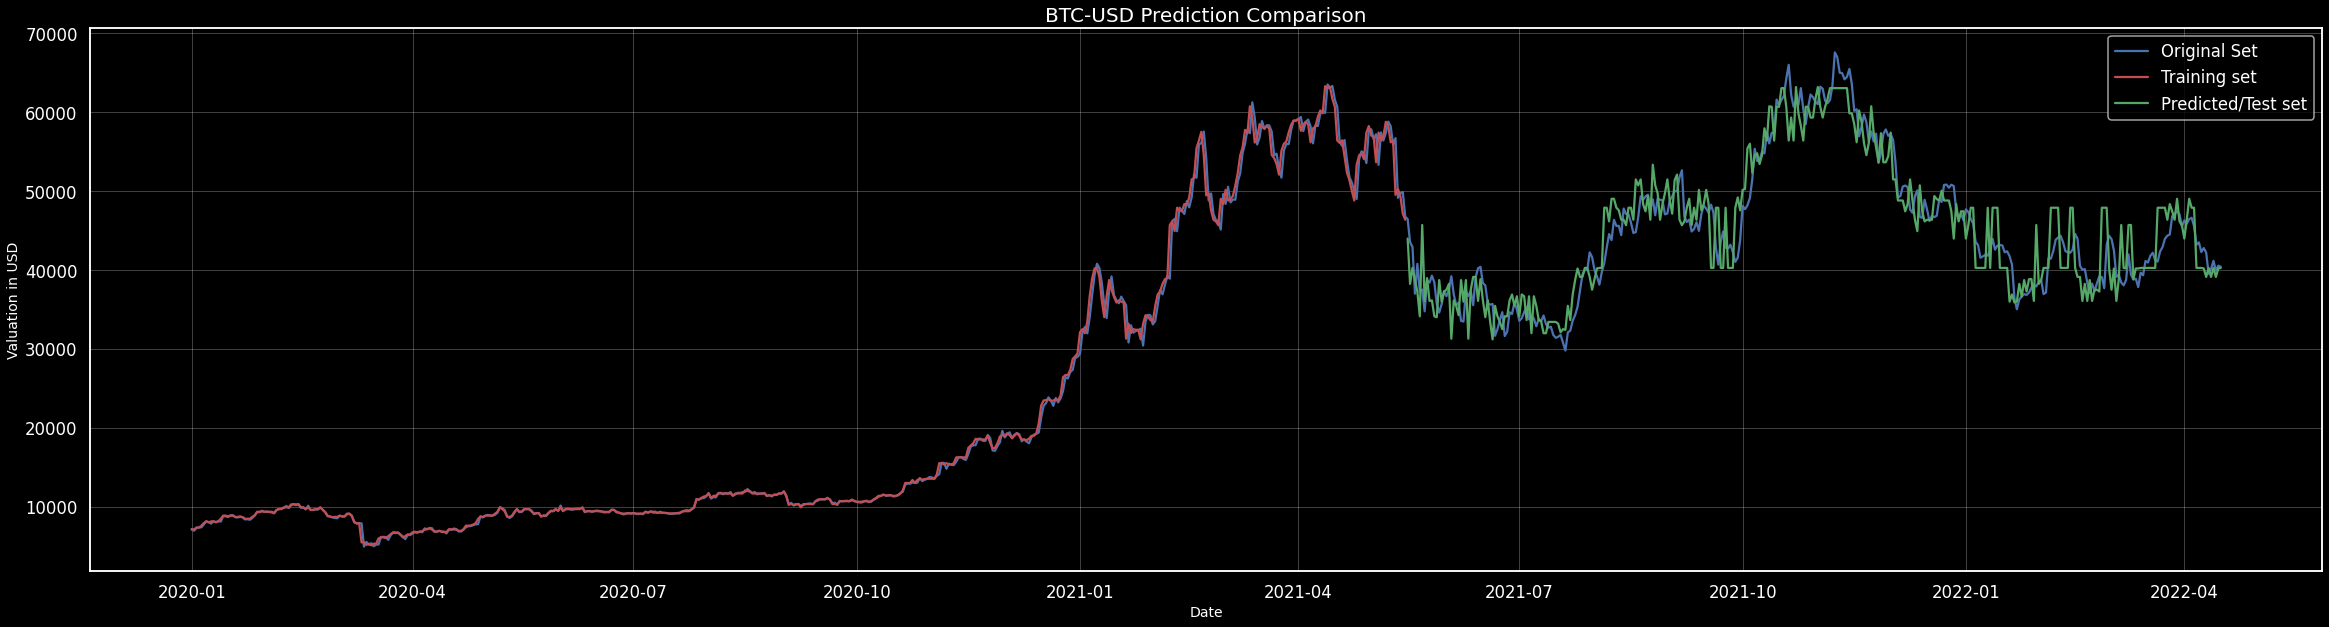

In [35]:
#@title Prediction Comparison { run: "auto" }
#@markdown Compare the actual vs predicted value
showDataframe = True #@param {type:"boolean"}
showTimeRange = False #@param {type:"boolean"}

realData = deepcopy(data).reset_index()
realData.index.names = ['idx']
predData = pd.DataFrame(data=np.append(trainPredict, testPredict), columns=[response])
predData.index.names = ['idx']

responseData = pd.merge(realData[['DATE', response]], predData, on="idx", how='inner' , suffixes=('_real', '_pred'))
responseData = responseData.reset_index().drop(['idx'], axis=1).set_index('DATE')
if showDataframe:
  responseData

# Visualisation of LTSM prediction
if showTimeRange:
  fig = px.line(responseData, x=responseData.index, y=responseData.columns, title=f'{coinTicker} Prediction Comparison')
  fig.update_xaxes(
      rangeslider_visible=True,
      rangeselector=dict(
          buttons=list([
              dict(count=1, label="1m", step="month", stepmode="backward"),
              dict(count=6, label="6m", step="month", stepmode="backward"),
              dict(count=1, label="YTD", step="year", stepmode="todate"),
              dict(count=1, label="1y", step="year", stepmode="backward"),
              dict(step="all")
          ])
      )
  )
else:
  fg = plt.figure(figsize=(40, 10))
  sb.lineplot(data=responseData, y=responseData[f"{response}_real"], color='b', x="DATE", label='Original Set')
  sb.lineplot(data=responseData, y=responseData[f"{response}_pred"][0:len(trainPredict)-1], color='r' , x="DATE", label='Training set')
  sb.lineplot(data=responseData, y=responseData[f"{response}_pred"][len(trainPredict)-1:len(responseData)], color='g', x="DATE", label='Predicted/Test set')
  plt.title(f'{coinTicker} Prediction Comparison', fontsize=20);
  plt.xlabel("Date", fontsize=14)
  plt.ylabel("Valuation in USD", fontsize=14)

### Forecast

---

In [36]:
#@title Add-on Libaries { run: "auto" }

from datetime import timedelta, date

In [37]:
#@title Forecast Period { run: "auto" }
#@markdown Define future timeframe coverage

daysAhead = 15    #@param {type:"number"}

if daysAhead > 0:
  startDate = responseData.tail(1).index.item() + timedelta(days=1)
  endDate = startDate + timedelta(days=daysAhead-1)

  forecastDates = pd.DataFrame(pd.date_range(startDate, endDate, freq='d'), columns=['DATE'])
  forecastDates.index.names = ['idx']
  forecastDates.loc[[0, len(forecastDates)-1]]
  print(f"No. of Days: {len(forecastDates.index)}")

,DATE
idx,
0,2022-04-17
14,2022-05-01


No. of Days: 15


In [38]:
# @title Model Forecast Prediction { run: "auto" }
# @markdown Using the LSTM model to predict future values

testZ = testData[len(testData)-time_step:].reshape(1,-1)
reframedTestZ=list(testZ)
reframedTestZ=reframedTestZ[0].tolist()


forecastData=[]
predDays = daysAhead

for day in range(0, daysAhead):
  if(len(reframedTestZ)>time_step):
      testZ=np.array(reframedTestZ[1:])
      #print("{} day input {}".format(i,testZ))
      testZ = testZ.reshape(1,-1)
      testZ = testZ.reshape((1, time_step))
      
      forecastPredict = model.predict(testZ)
      #print("{} day output {}".format(i,forecastPredict))
      reframedTestZ.extend(forecastPredict.tolist())
      reframedTestZ=reframedTestZ[1:]
      
      forecastData.extend(forecastPredict.tolist())
  else:
      testZ = testZ.reshape((1, time_step))
      forecastPredict = model.predict(testZ)
      reframedTestZ.extend(forecastPredict.tolist())
      
      forecastData.extend(forecastPredict.tolist())

               
print("Output of predicted next days: ", len(forecastData))

# DE-Normalizing for plotting 
forecastData = scaler.inverse_transform(np.array(forecastData).reshape(-1,1))
forecastData = pd.DataFrame(forecastData, columns=[response])
forecastData.index.names = ['idx']

fDate = deepcopy(forecastDates)
fPred = deepcopy(forecastData)
fData = pd.merge(fDate, fPred, on="idx", how='inner' )

rData = deepcopy(responseData)[[f"{response}_pred"]].reset_index()
rData.index.names = ['idx']
rData.rename({f"{response}_pred":response}, axis=1, inplace=True)

forecastPredictionData = pd.concat([rData, fData], axis=0)
forecastPredictionData

Output of predicted next days:  15


,DATE,CLOSE
idx,,
0,2020-01-01,"7,133.31"
1,2020-01-02,"7,165.04"
2,2020-01-03,"7,374.81"
3,2020-01-04,"7,374.81"
4,2020-01-05,"7,618.11"
...,...,...
10,2022-04-27,"45,677.40"
11,2022-04-28,"45,677.40"
12,2022-04-29,"45,677.40"


,CLOSE_real,CLOSE_pred
DATE,,
2021-12-03,"53,598.25","51,479.95"
2021-12-04,"49,200.70","48,809.27"
2021-12-05,"49,368.85","48,809.27"
2021-12-06,"50,582.62","48,809.27"
2021-12-07,"50,700.09","47,438.27"
...,...,...
2022-04-27,NaN,"45,677.40"
2022-04-28,NaN,"45,677.40"
2022-04-29,NaN,"45,677.40"


Text(0.5, 1.0, 'BTC-USD Prediction Comparison')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Valuation in USD')

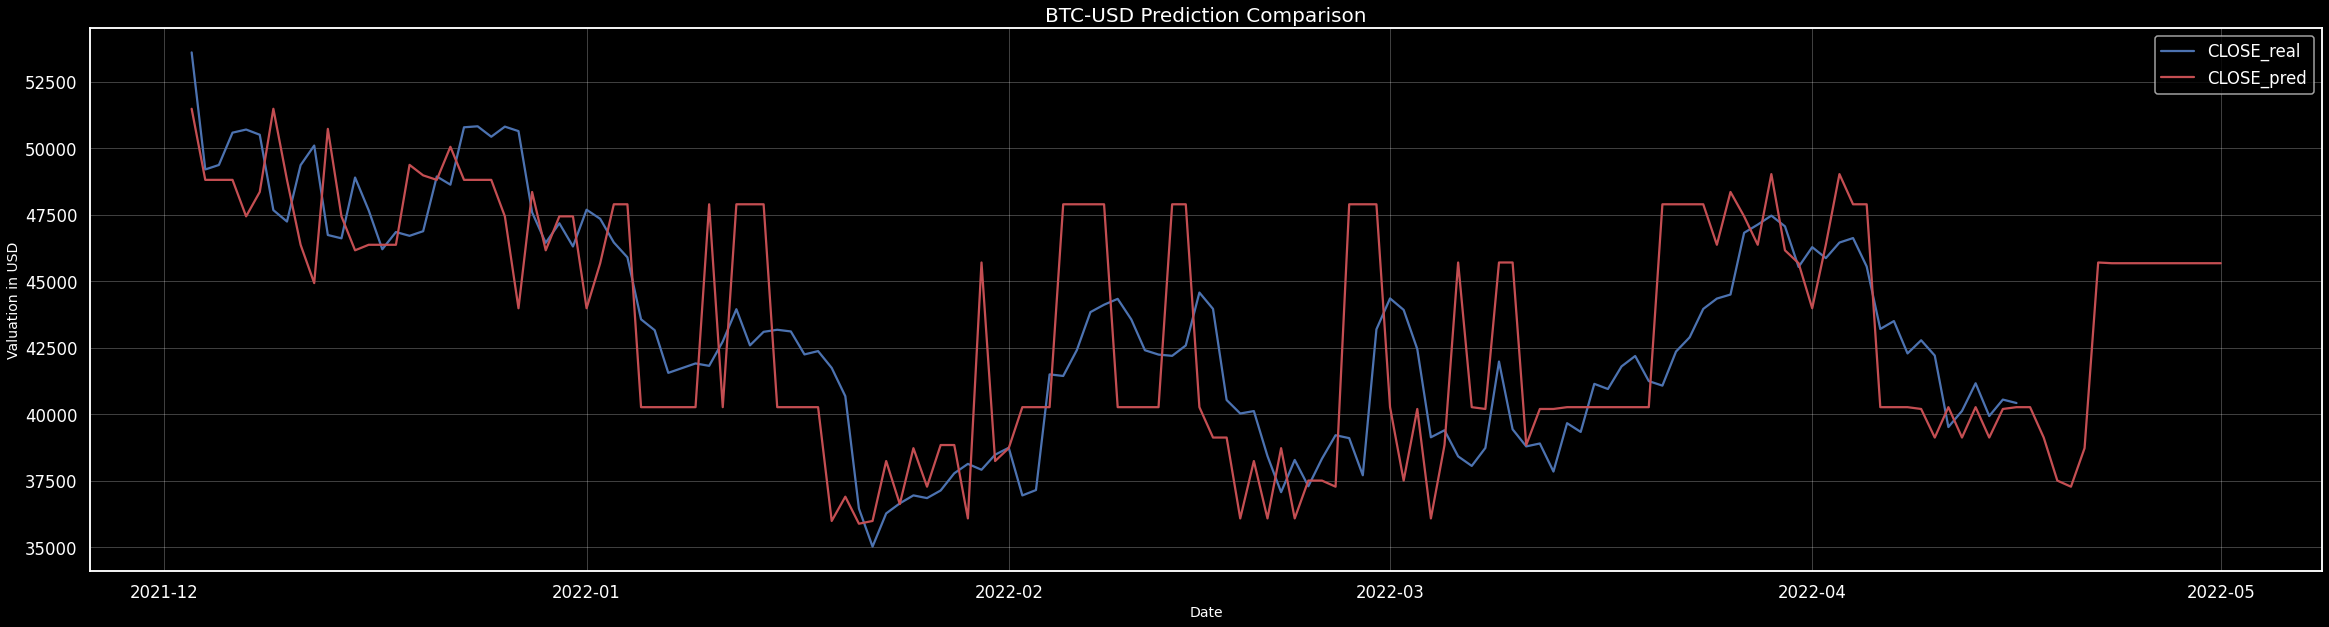

In [39]:
#@title Prediction Comparison { run: "auto" }
#@markdown Compare the actual vs predicted value
showDataframe = True #@param {type:"boolean"}
showTimeRange = False #@param {type:"boolean"}

fpd = deepcopy(forecastPredictionData)

rd = deepcopy(responseData)[[f"{response}_real"]].reset_index()
rd.index.names = ['idx']
rd.rename({f"{response}_real":response}, axis=1, inplace=True)

fpd = fpd.merge(rd, on='DATE', how='left', suffixes=('_pred', '_real'))
fpd = fpd[fpd.columns[[0, 2, 1]]].set_index('DATE').iloc[-(daysAhead * 10):]
if showDataframe:
  fpd

# Visualisation of LTSM prediction
if showTimeRange:
  fig = px.line(fpd, x=fpd.index, y=fpd.columns, title=f'{coinTicker} Prediction Comparison')
  fig.update_xaxes(
      rangeslider_visible=True,
      rangeselector=dict(
          buttons=list([
              dict(count=1, label="1m", step="month", stepmode="backward"),
              dict(count=6, label="6m", step="month", stepmode="backward"),
              dict(count=1, label="YTD", step="year", stepmode="todate"),
              dict(count=1, label="1y", step="year", stepmode="backward"),
              dict(step="all")
          ])
      )
  )
else:
  fg = plt.figure(figsize=(40, 10))
  colors = ['b', 'r', 'g', 'c', 'm', 'y']
  for idx, col in enumerate(fpd.columns):
    sb.lineplot(data=fpd, x=fpd.index, y=col, color=colors[idx], label=col)
  plt.title(f'{coinTicker} Prediction Comparison', fontsize=20);
  plt.xlabel("Date", fontsize=14)
  plt.ylabel("Valuation in USD", fontsize=14)


allForecasts = {}
allForecasts[modelType] = {
    'MODEL': model,
    'FORECAST': fpd
}

## LSTM
---

In [40]:
#@title Normalisation { run: "auto" }
#@markdown Dataset values are normalized by using MinMax method.

data = deepcopy(mainData)

scaler = MinMaxScaler(feature_range=(0,1))
# scaledData = scaler.fit_transform(np.reshape(data.values, (len(data),1)))
scaledData = scaler.fit_transform(np.array(data).reshape(-1,1))

# Preview dataset
pd.concat([data.reset_index(), pd.DataFrame(scaledData, columns=[f'SCALED-{response}'])], axis=1)

,DATE,CLOSE,SCALED-CLOSE
0,2020-01-01,"7,200.17",0.04
1,2020-01-02,"6,985.47",0.03
2,2020-01-03,"7,344.88",0.04
3,2020-01-04,"7,410.66",0.04
4,2020-01-05,"7,411.32",0.04
...,...,...,...
836,2022-04-16,"40,424.48",0.57
837,2022-04-17,"39,716.95",0.56
838,2022-04-18,"40,826.21",0.57
839,2022-04-19,"41,502.75",0.58


In [41]:
#@title Train/Test Split { run: "auto" }
#@markdown Dataset is splitted into two groups which are train and test sets.

modelData = deepcopy(scaledData)
trainSize = int(len(modelData)*0.60)
testSize = len(modelData)-trainSize
trainData, testData = modelData[0:trainSize,:],modelData[trainSize:len(modelData),:1]

# Normalized values are converted into Time-Series.
def to_singleDim(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 1
trainX, trainY = to_singleDim(trainData, time_step)
testX, testY = to_singleDim(testData, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
trainX = trainX.reshape(trainX.shape[0],trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0],testX.shape[1], 1)

pd.DataFrame({
  'X':{
    'Train': trainX.shape,
    'Test': testX.shape,
  },
  'Y':{
    'Train': trainY.shape,
    'Test': testY.shape,
  }
})

,X,Y
Train,"(502, 1, 1)","(502,)"
Test,"(335, 1, 1)","(335,)"


In [42]:
#@title Model Initialisation { run: "auto" }
#@markdown LSTM model is created and adjusted neuron structure

modelType = 'uniLSTM'

model = Sequential()
# model.add(LSTM(128, input_shape=(1, time_step)))
model.add(LSTM(128,input_shape=(None,1),activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

# Dataset is trained by using trainX and trainY
history = model.fit(trainX,trainY,validation_data=(testX,testY),epochs=200,batch_size=32,verbose=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
16/16 [==============================] - 5s 63ms/step - loss: 0.1357 - val_loss: 0.3425
Epoch 2/200
16/16 [==============================] - 0s 14ms/step - loss: 0.1087 - v

Text(0.5, 1.0, 'Test and Train set Loss Value Rate')

Text(0.5, 0, 'Epochs Number')

Text(0, 0.5, 'Loss Value')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SUCCESSFULL EXPORTED to [BTC-uniLSTM.h5]


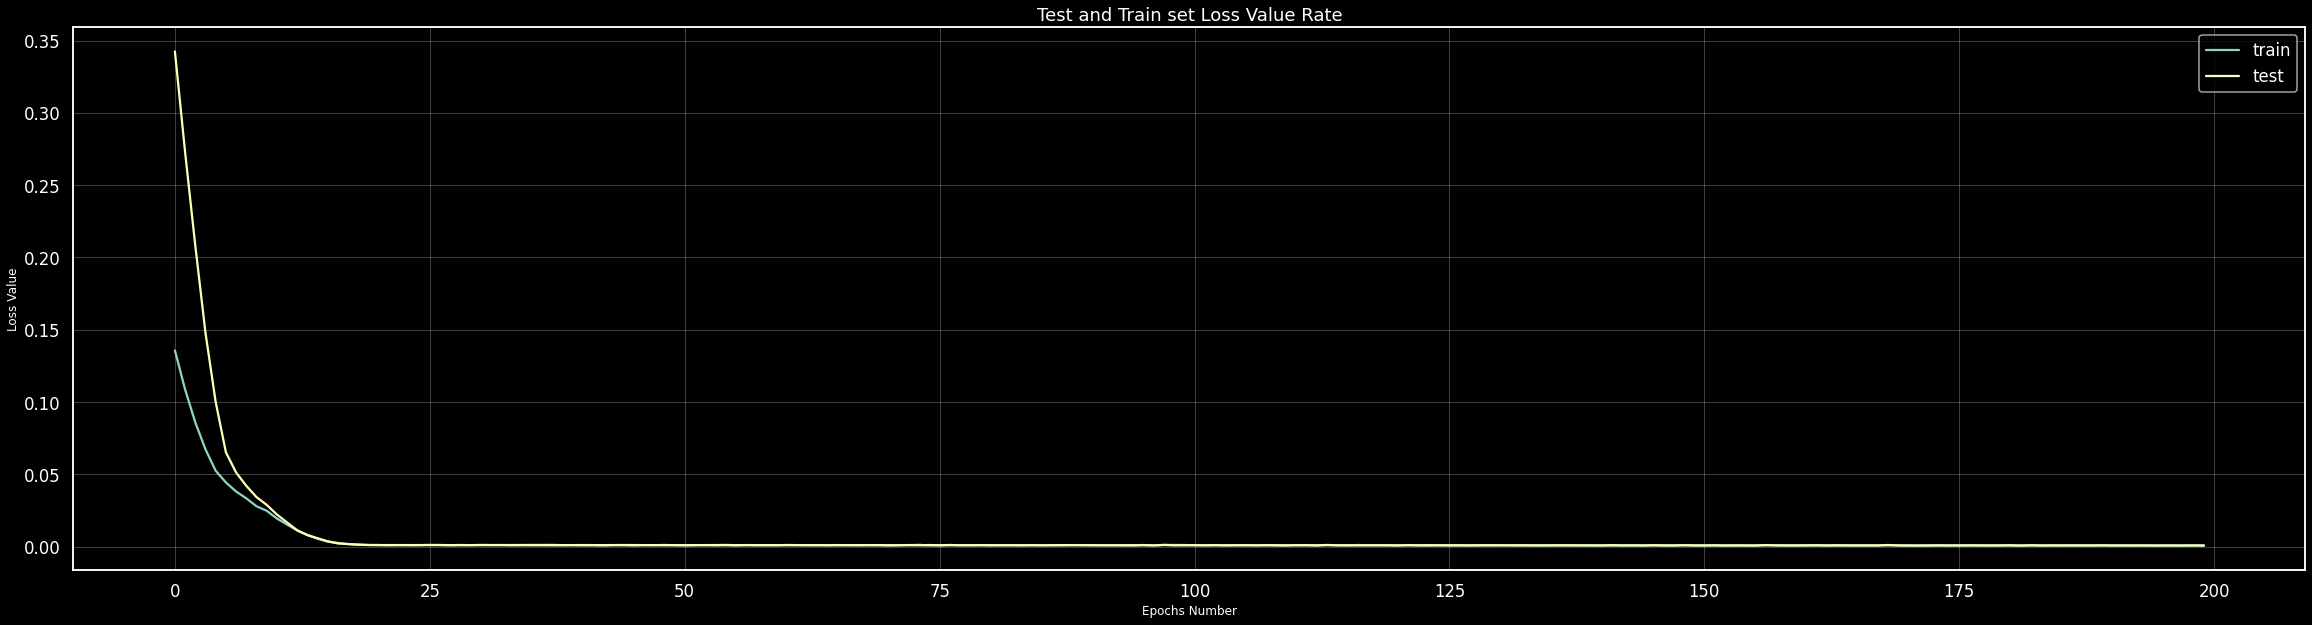

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

# Visualisation of loss values for every traing epoch
fg, ax = plt.subplots(figsize=(40, 10))
plt.title("Test and Train set Loss Value Rate")
plt.xlabel('Epochs Number', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
sb.lineplot(data=loss, label='train')
sb.lineplot(data=val_loss, label='test')

exportModel = True #@param {type:"boolean"}

# Export Model
if exportModel:
  fileName = f"{coinTicker.split('-')[0]}-{modelType}.h5"
  folderPath = "" #@param {type:"string"} 
  if len(folderPath) > 0 and not folderPath.endswith('/'):
    folderPath += '/'
  filePath = f'{folderPath if len(folderPath) > 0 else ""}{fileName}'

  if onColab:
    if onDrive:
      filePath = f'/content/drive/My Drive/{filePath}'
      model.save(filePath)
      print(f"SUCCESSFULL EXPORTED to [{filePath}]")
    else:
      model.save(fileName)
      files.download(fileName)
      print(f"SUCCESSFULL EXPORTED to [{fileName}]")
  else:
    BASE_DIR = os.getcwd()
    filePath = os.path.join(BASE_DIR, filePath)
    model.save(filePath, encoding='utf-8', index=False)
    print(f"SUCCESSFULL EXPORTED to [{filePath}]")

In [44]:
#@title Model Prediction { run: "auto" }
#@markdown Using the LSTM model to predict Train / Test values

# Prediction process is performed for Train/Test dataset
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# DE-Normalizing for plotting 
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
trainReal = scaler.inverse_transform(trainY.reshape(-1,1)) 
testReal = scaler.inverse_transform(testY.reshape(-1,1)) 

# Model Evaluation
trainMetrics = {
    'RMSE': sqrt(mean_squared_error(trainReal,trainPredict)),
    'MSE': mean_squared_error(trainReal,trainPredict),
    'MAE': mean_absolute_error(trainReal,trainPredict),
    'EV': explained_variance_score(trainReal, trainPredict),
    'R2':  r2_score(trainReal, trainPredict),
    'MGD':  mean_gamma_deviance(trainReal, trainPredict),
    'MPD':  mean_poisson_deviance(trainReal, trainPredict),
}
testMetrics = {
    'RMSE': sqrt(mean_squared_error(testReal,testPredict)),
    'MSE': mean_squared_error(testReal,testPredict),
    'MAE': mean_absolute_error(testReal,testPredict),
    'EV': explained_variance_score(testReal, testPredict),
    'R2':  r2_score(testReal, testPredict),
    'MGD':  mean_gamma_deviance(testReal, testPredict),
    'MPD':   mean_poisson_deviance(testReal, testPredict),
}

# Compile/Export Metrics
metrics = {}
metrics[modelType] = {
  'TRAIN':trainMetrics,
  'TEST':testMetrics
}

exportJSON = True #@param {type:"boolean"}

# Export to CSV
if exportJSON:
  allMetrics = pd.DataFrame.from_dict(metrics,orient='columns')
  
  fileName = f"{modelType}_metrics.json"
  folderPath = "" #@param {type:"string"} 
  if len(folderPath) > 0 and not folderPath.endswith('/'):
    folderPath += '/'
  filePath = f'{folderPath if len(folderPath) > 0 else ""}{fileName}'

  if onColab:
    if onDrive:
      filePath = f'/content/drive/My Drive/{filePath}'
      allMetrics.to_json(filePath, orient='columns')
      print(f"SUCCESSFULLY EXPORTED to [{filePath}]")
    else:
      allMetrics.to_json(fileName, orient='columns')
      files.download(fileName)
      print(f"SUCCESSFULLY EXPORTED to [{fileName}]")

  else:
    BASE_DIR = os.getcwd()
    filePath = os.path.join(BASE_DIR, filePath)
    allMetrics.to_json(filePath, orient='columns')
    print(f"SUCCESSFULLY EXPORTED to [{filePath}]")


# Display summary sorted by R-squared (R2) in descending order
pd.DataFrame.from_dict({(i,j): metrics[i][j] 
                            for i in metrics.keys() 
                            for j in metrics[i].keys()},
                        orient='index').rename_axis("TYPE", axis=1).sort_values(by="R2", ascending=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SUCCESSFULLY EXPORTED to [uniLSTM_metrics.json]


TYPE              RMSE          MSE      MAE   EV   R2  MGD   MPD
uniLSTM TRAIN 1,240.50 1,538,840.00   687.74 1.00 1.00 0.00 47.72
        TEST  1,678.79 2,818,325.60 1,253.60 0.96 0.96 0.00 62.54

In [45]:
#@title Metrics Summary Import { run: "auto" }
#@markdown Compare and export the model metrics

importMetrics = False #@param {type:"boolean"}

if importMetrics:
  fileName = f"{modelType}_metrics.json"
  folderPath = "" #@param {type:"string"} 

  if onColab:
    if onDrive:
      folderPath = f'/content/drive/My Drive/{folderPath if len(folderPath) > 0 else ""}'
    else:
      folderPath = f"/content/{folderPath if len(folderPath) > 0 else ''}"
  else:
    BASE_DIR = os.getcwd()
    folderPath = os.path.join(BASE_DIR, f"{folderPath if len(folderPath) > 0 else ''}")
  filePath = f'{folderPath}{fileName}'

  # Import CSV 
  try:
    sm = pd.read_json(filePath, orient="columns")
    # Display summary sorted by R-squared (R2) in descending order
    pd.DataFrame.from_dict({(i,j): sm[i][j] 
                              for i in sm.keys() 
                              for j in sm[i].keys()},
                          orient='index').rename_axis("TYPE", axis=1).sort_values(by="R2", ascending=False)
  except FileNotFoundError:
      print("ERROR - FILE NOT FOUND. [Run 'Data Preprocess' to export the file.]")

,CLOSE_real,CLOSE_pred
DATE,,
2020-01-01,"7,200.17","7,382.59"
2020-01-02,"6,985.47","7,224.37"
2020-01-03,"7,344.88","7,511.39"
2020-01-04,"7,410.66","7,572.73"
2020-01-05,"7,411.32","7,573.35"
...,...,...
2022-04-12,"40,127.18","39,795.73"
2022-04-13,"41,166.73","40,428.00"
2022-04-14,"39,935.52","40,295.97"


Text(0.5, 1.0, 'BTC-USD Prediction Comparison')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Valuation in USD')

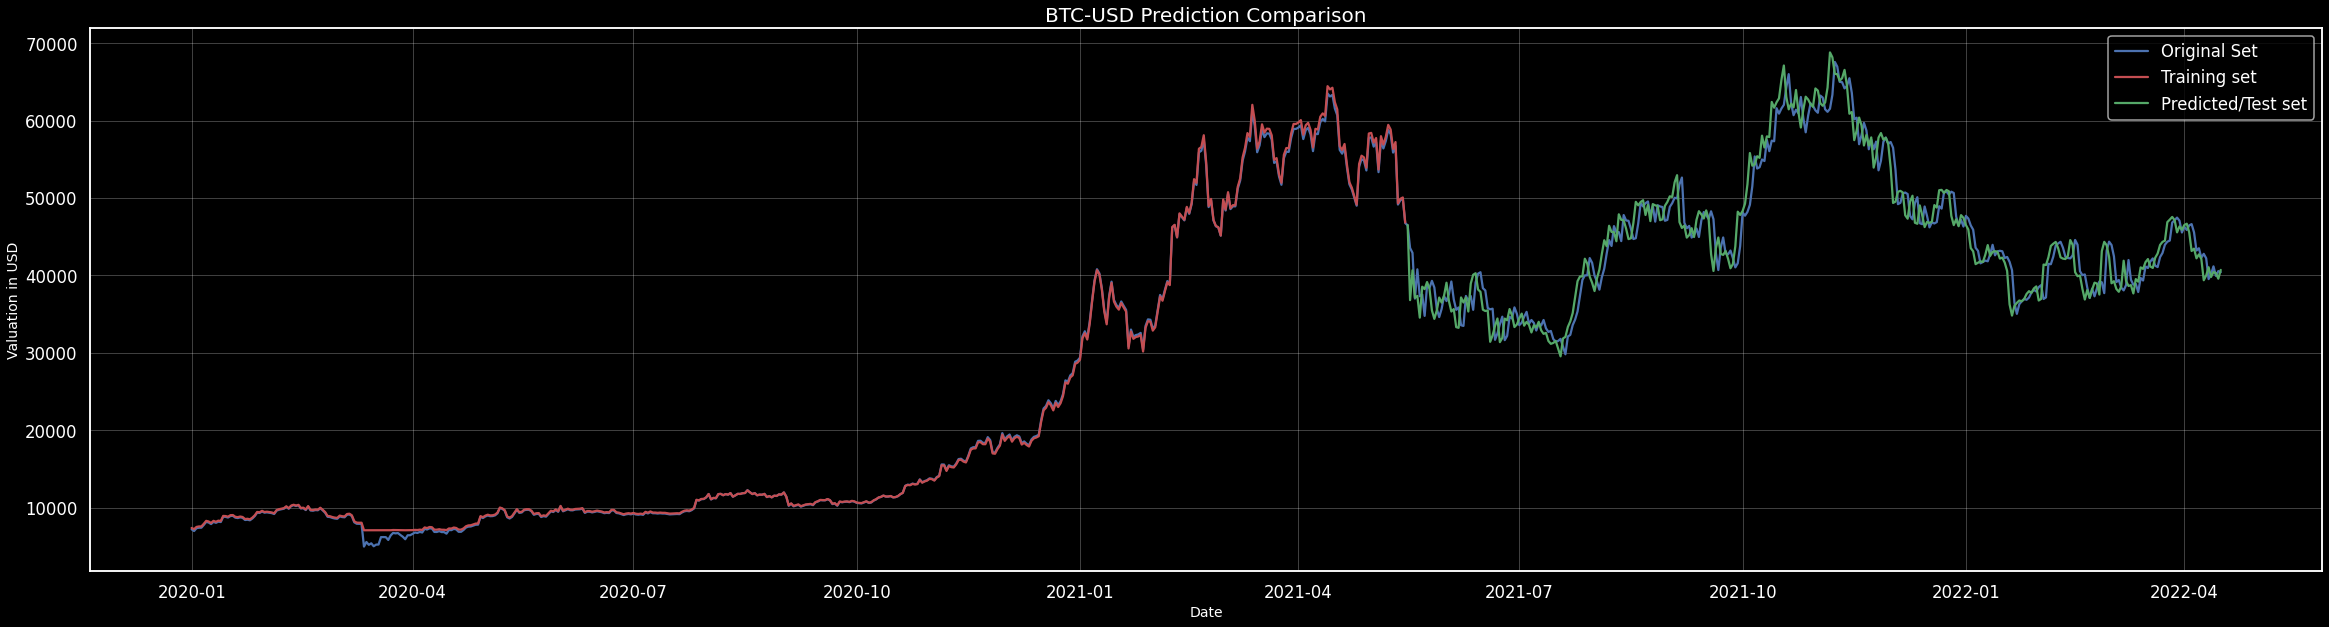

In [46]:
#@title Prediction Comparison { run: "auto" }
#@markdown Compare the actual vs predicted value
showDataframe = True #@param {type:"boolean"}
showTimeRange = False #@param {type:"boolean"}

realData = deepcopy(data).reset_index()
realData.index.names = ['idx']
predData = pd.DataFrame(data=np.append(trainPredict, testPredict), columns=[response])
predData.index.names = ['idx']

responseData = pd.merge(realData[['DATE', response]], predData, on="idx", how='inner' , suffixes=('_real', '_pred'))
responseData = responseData.reset_index().drop(['idx'], axis=1).set_index('DATE')
if showDataframe:
  responseData

# Visualisation of LTSM prediction
if showTimeRange:
  fig = px.line(responseData, x=responseData.index, y=responseData.columns, title=f'{coinTicker} Prediction Comparison')
  fig.update_xaxes(
      rangeslider_visible=True,
      rangeselector=dict(
          buttons=list([
              dict(count=1, label="1m", step="month", stepmode="backward"),
              dict(count=6, label="6m", step="month", stepmode="backward"),
              dict(count=1, label="YTD", step="year", stepmode="todate"),
              dict(count=1, label="1y", step="year", stepmode="backward"),
              dict(step="all")
          ])
      )
  )
else:
  fg = plt.figure(figsize=(40, 10))
  sb.lineplot(data=responseData, y=responseData[f"{response}_real"], color='b', x="DATE", label='Original Set')
  sb.lineplot(data=responseData, y=responseData[f"{response}_pred"][0:len(trainPredict)-1], color='r' , x="DATE", label='Training set')
  sb.lineplot(data=responseData, y=responseData[f"{response}_pred"][len(trainPredict)-1:len(responseData)], color='g', x="DATE", label='Predicted/Test set')
  plt.title(f'{coinTicker} Prediction Comparison', fontsize=20);
  plt.xlabel("Date", fontsize=14)
  plt.ylabel("Valuation in USD", fontsize=14)

### Forecast

---

In [47]:
#@title Add-on Libaries { run: "auto" }

from datetime import timedelta, date

In [48]:
#@title Forecast Period { run: "auto" }
#@markdown Define future timeframe coverage

daysAhead = 15    #@param {type:"number"}

if daysAhead > 0:
  startDate = responseData.tail(1).index.item() + timedelta(days=1)
  endDate = startDate + timedelta(days=daysAhead-1)

  forecastDates = pd.DataFrame(pd.date_range(startDate, endDate, freq='d'), columns=['DATE'])
  forecastDates.index.names = ['idx']
  forecastDates.loc[[0, len(forecastDates)-1]]
  print(f"No. of Days: {len(forecastDates.index)}")

,DATE
idx,
0,2022-04-17
14,2022-05-01


No. of Days: 15


In [49]:
# @title Model Forecast Prediction { run: "auto" }
# @markdown Using the LSTM model to predict future values

testZ = testData[len(testData)-time_step:].reshape(1,-1)
reframedTestZ=list(testZ)
reframedTestZ=reframedTestZ[0].tolist()

forecastData=[]
predDays = daysAhead

for day in range(0, daysAhead):
  if(len(reframedTestZ)>time_step):
      testZ=np.array(reframedTestZ[1:])
      #print("{} day input {}".format(i,testZ))
      testZ = testZ.reshape(1,-1)
      testZ = testZ.reshape((1, time_step, 1))
      
      forecastPredict = model.predict(testZ, verbose=0)
      #print("{} day output {}".format(i,forecastPredict))
      reframedTestZ.extend(forecastPredict[0].tolist())
      reframedTestZ=reframedTestZ[1:]
      
      forecastData.extend(forecastPredict.tolist())
  else:
      testZ = testZ.reshape((1, time_step,1))
      forecastPredict = model.predict(testZ, verbose=0)
      reframedTestZ.extend(forecastPredict[0].tolist())
      
      forecastData.extend(forecastPredict.tolist())

               
print("Output of predicted next days: ", len(forecastData))

# DE-Normalizing for plotting 
forecastData = scaler.inverse_transform(forecastData)
forecastData = pd.DataFrame(forecastData, columns=[response])
forecastData.index.names = ['idx']

fDate = deepcopy(forecastDates)
fPred = deepcopy(forecastData)
fData = pd.merge(fDate, fPred, on="idx", how='inner' )

rData = deepcopy(responseData)[[f"{response}_pred"]].reset_index()
rData.index.names = ['idx']
rData.rename({f"{response}_pred":response}, axis=1, inplace=True)

forecastPredictionData = pd.concat([rData, fData], axis=0)
forecastPredictionData

Output of predicted next days:  15


,DATE,CLOSE
idx,,
0,2020-01-01,"7,382.59"
1,2020-01-02,"7,224.37"
2,2020-01-03,"7,511.39"
3,2020-01-04,"7,572.73"
4,2020-01-05,"7,573.35"
...,...,...
10,2022-04-27,"40,663.37"
11,2022-04-28,"40,540.53"
12,2022-04-29,"40,414.76"


,CLOSE_real,CLOSE_pred
DATE,,
2021-12-03,"53,598.25","49,529.30"
2021-12-04,"49,200.70","50,794.39"
2021-12-05,"49,368.85","50,916.97"
2021-12-06,"50,582.62","50,713.19"
2021-12-07,"50,700.09","47,765.68"
...,...,...
2022-04-27,NaN,"40,663.37"
2022-04-28,NaN,"40,540.53"
2022-04-29,NaN,"40,414.76"


Text(0.5, 1.0, 'BTC-USD Prediction Comparison')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Valuation in USD')

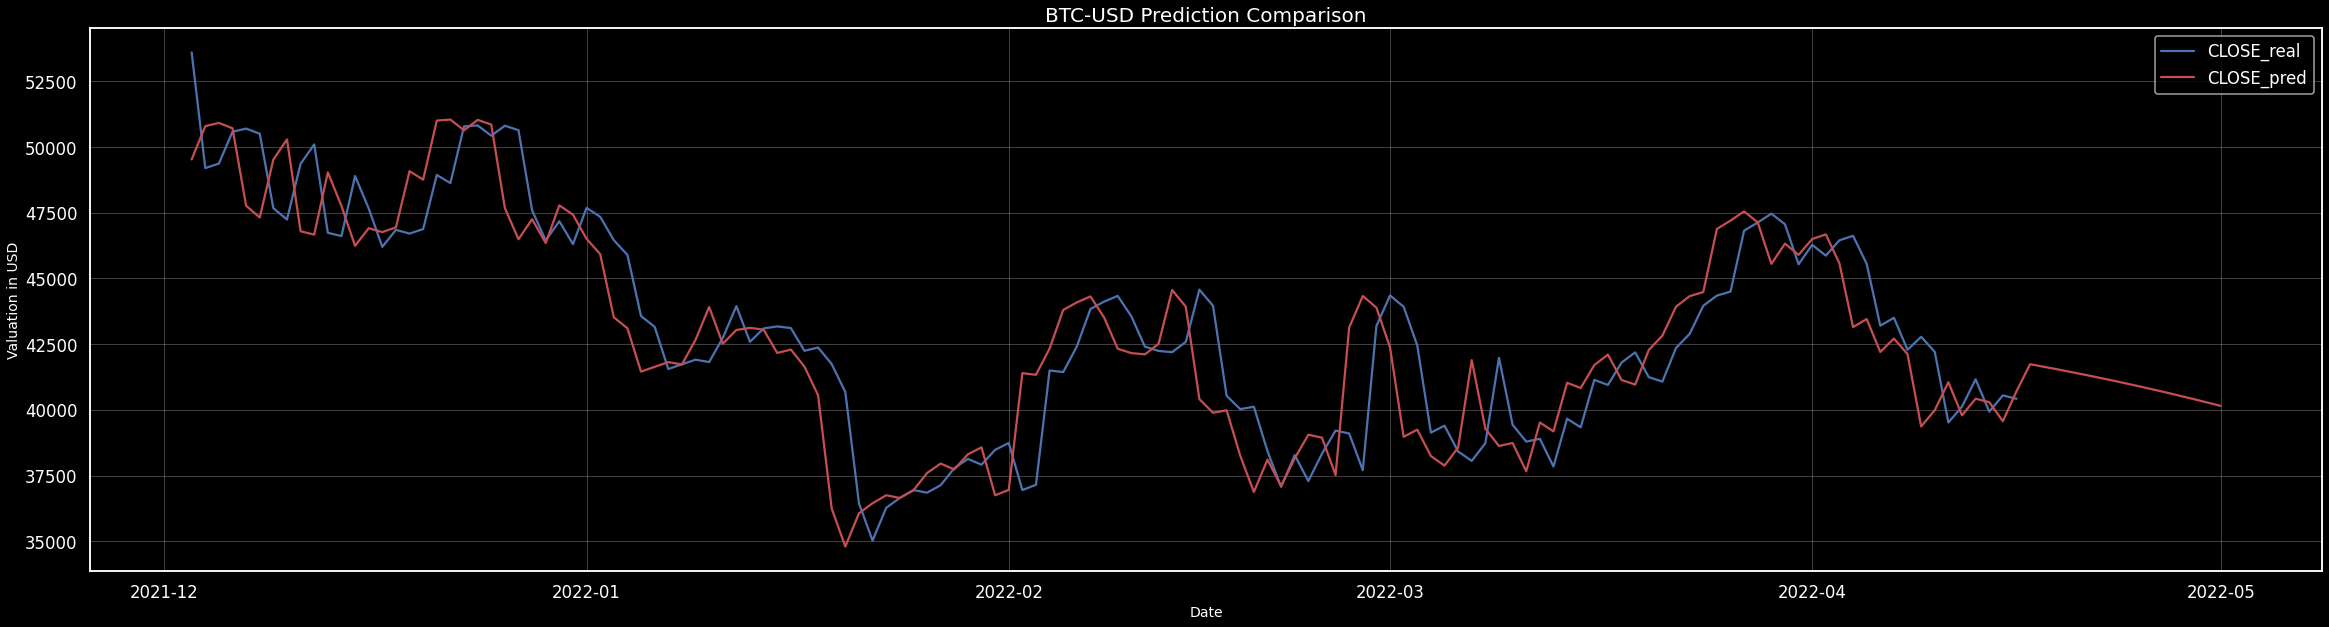

In [50]:
#@title Prediction Comparison { run: "auto" }
#@markdown Compare the actual vs predicted value
showDataframe = True #@param {type:"boolean"}
showTimeRange = False #@param {type:"boolean"}

fpd = deepcopy(forecastPredictionData)

rd = deepcopy(responseData)[[f"{response}_real"]].reset_index()
rd.index.names = ['idx']
rd.rename({f"{response}_real":response}, axis=1, inplace=True)

fpd = fpd.merge(rd, on='DATE', how='left', suffixes=('_pred', '_real'))
fpd = fpd[fpd.columns[[0, 2, 1]]].set_index('DATE').iloc[-(daysAhead * 10):]
if showDataframe:
  fpd

# Visualisation of LTSM prediction
if showTimeRange:
  fig = px.line(fpd, x=fpd.index, y=fpd.columns, title=f'{coinTicker} Prediction Comparison')
  fig.update_xaxes(
      rangeslider_visible=True,
      rangeselector=dict(
          buttons=list([
              dict(count=1, label="1m", step="month", stepmode="backward"),
              dict(count=6, label="6m", step="month", stepmode="backward"),
              dict(count=1, label="YTD", step="year", stepmode="todate"),
              dict(count=1, label="1y", step="year", stepmode="backward"),
              dict(step="all")
          ])
      )
  )
else:
  fg = plt.figure(figsize=(40, 10))
  colors = ['b', 'r', 'g', 'c', 'm', 'y']
  for idx, col in enumerate(fpd.columns):
    sb.lineplot(data=fpd, x=fpd.index, y=col, color=colors[idx], label=col)
  plt.title(f'{coinTicker} Prediction Comparison', fontsize=20);
  plt.xlabel("Date", fontsize=14)
  plt.ylabel("Valuation in USD", fontsize=14)

allForecasts[modelType] = {
    'MODEL': model,
    'FORECAST': fpd
}

---

## Model Evaluation

---

In [51]:
#@title Compilation Model Metrics { run: "auto" }
#@markdown Merge summary metrics<br/>
#@markdown Reference: [Import & Concat multiple CSV](https://stackoverflow.com/a/55436079)

import glob

combineMetrics = True #@param {type:"boolean"}

if combineMetrics:
  
  folderPath = "" #@param {type:"string"}
  if len(folderPath) > 0 and not folderPath.endswith('/'):
    folderPath += '/'

  if onColab:
    if onDrive:
      folderPath = f'/content/drive/My Drive/{folderPath if len(folderPath) > 0 else ""}'
    else:
      folderPath = f"/content/{folderPath if len(folderPath) > 0 else ''}"
  filesPath = f'{folderPath}*.json'

  try:
    allMetrics = []
    for f in glob.glob(filesPath):
      sm = pd.read_json(f, orient="columns")
      allMetrics.append(sm)

    if len(allMetrics):
      # Fetch all files from folder path
      print(f"SUCCESSFULLY IMPORTED from [{filesPath}]")

      sm = pd.concat(allMetrics, axis=1).drop('TRAIN')
      # Display summary sorted by R-squared (R2) in descending order
      sm = pd.DataFrame.from_dict({(i,j): sm[i][j] 
                                for i in sm.keys() 
                                for j in sm[i].keys()},
                            orient='index').rename_axis("TYPE", axis=1).sort_values(by="R2", ascending=False)

      sm
  except FileNotFoundError:
    print("ERROR - FILE NOT FOUND. [Run 'Data Preprocess' to export the file.]")

SUCCESSFULLY IMPORTED from [/content/*.json]


,TYPE,RMSE,MSE,MAE,EV,R2,MGD,MPD
uniLSTM,TEST,"1,678.79","2,818,325.60","1,253.60",0.96,0.96,0.00,62.54
rollingARIMA,TEST,"1,634.19","2,670,569.98","1,192.10",0.96,0.96,0.00,55.52
XGBoost,TEST,"2,675.77","7,159,763.50","2,081.96",0.90,0.90,0.00,159.05


---